In [1]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils import convert_episodes_to_traj_class
import evaluation_metrics as em
import parameters as p
import utils
import glob
from collections import Counter
import joblib

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [57]:
figpath = '/Users/us3519/mouse-maze/figs/paper figs/figure_results'

In [4]:
# Calculating KL-divergence between learned state-action probability distribution vs estimated from the data.

In [14]:
from scipy.stats import entropy
from scipy.special import kl_div, rel_entr, entr
from scipy.stats import ttest_ind, ttest_rel

In [232]:
model_colors = {
    'Animals': 'r',
    'TeAltOptions': 'g',
    'BiasedWalk4': 'y',
#     'MarkovChain': 'm',
    'RandomWalk': 'b',
    'Optimal': 'k:',
    'Uncertainty': 'tab:pink',
}

In [462]:
labels = {
    'Animals':      'Animals',
    'TeAltOptions': '$\epsilon$$z$-Greedy',
    'BiasedWalk4':  'Biased Walk',
    'Uncertainty':  'Uncertainty',
    'RandomWalk':   'random',
    'Optimal':      'optimal',
}

In [242]:
def load(model_name):
    if model_name == 'Animals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in UnrewNamesSub]
        return tfs

#     if model_name == 'BiasedWalk':
#         tfs = [LoadTrajFromPath(f'../outdata/{_}-RW5-tf') for _ in UnrewNamesSub]
#         return tfs
    
#     if model_name == 'RandomWalk':
#         tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
#         return tfs
    
    if model_name == 'MarkovChain':
        tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
        return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=500000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [127]:
def get_prob_dist(samples_count_dict, support, alpha=1e-6):
    counts = Counter(samples_count_dict)
    probs = np.array([counts[a] + alpha for a in support], dtype=np.float64)
    probs /= probs.sum()
    return probs

In [458]:
var = False
tju = True  # masking endnodes make sense, as there is only one action there

entr_animal_tes = {}
entr_animal_bws = {}
entr_animal_uncs = {}

for par in range(1, 7):
    print(f"=============== At depth={par} ==================")
    entr_animal_tes[par] = []
    entr_animal_bws[par] = []
    entr_animal_uncs[par] = []

    biasedwalk_tf = load('BiasedWalk4')[0]
    hi_bw, _, _, pt_dict_bw = em.markov_fit_pooling_pr(biasedwalk_tf, re=False, tju=tju, var=var, par=par)
#     print('Biased Walk:', hi_bw, len(pt_dict_bw))

    tealtopt_tf = load('TeAltOptions')[0]
    hi_te, _, _, pt_dict_tealtopt = em.markov_fit_pooling_pr(tealtopt_tf, re=False, tju=tju, var=var, par=par)
    
    unc_tf = load('Uncertainty')[0]
    hi_unc, _, _, pt_dict_unc = em.markov_fit_pooling_pr(unc_tf, re=False, tju=tju, var=var, par=par)
#     print('Uncertainty:', hi_unc, len(pt_dict_unc))

    for nickname in p.UnrewNamesSub:
        tf = LoadTrajFromPath(f'../outdata/{nickname}-tf')
#         tf = LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{nickname}-MarkovSim-tf')
        hi_animal, _, _, pt_dict_animal = em.markov_fit_pooling_pr(tf, re=False, tju=tju, var=var, par=par)
#         print(f'{nickname}:', hi_animal, len(pt_dict_animal))

        support = sorted(set(pt_dict_animal) | set(pt_dict_tealtopt) | set(pt_dict_bw) | set(pt_dict_unc)) # create shared support
#         print(support[:100])
        print("len(support):", len(support))

        pt_animal = get_prob_dist(pt_dict_animal, support)
        pt_te = get_prob_dist(pt_dict_tealtopt, support)
        pt_bw = get_prob_dist(pt_dict_bw, support)
        pt_unc = get_prob_dist(pt_dict_unc, support)

        entr_animal_te = np.sum(rel_entr(pt_animal, pt_te))
        entr_animal_bw = np.sum(rel_entr(pt_animal, pt_bw))
        entr_animal_unc = np.sum(rel_entr(pt_animal, pt_unc))

#         print('te:', entr_animal_te)
#         print('bw:', entr_animal_bw)

        entr_animal_tes[par].append(entr_animal_te)
        entr_animal_bws[par].append(entr_animal_bw)
        entr_animal_uncs[par].append(entr_animal_unc)
#         print()

=============== At depth=1 ==================
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 1

len(support): 96
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
len(support): 96
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
len(support): 96
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9

tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
len(support): 714
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
len(support): 714
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9

tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11 12 12 11 11
 12 12 11 11 12 12 11]
tra [ 0  1  2  3  4  4  3  6  5  5  6  6  5  5  6  7  8  8  7  7  8  8  7  7
  8  8  7  7  8  8  7 10  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 10
  9  9 10 10  9  9 10 10  9  9 10 10  9  9 10 11 12 12 11 11 12 12

depth 1
t-statistic: 16.159939808220653
p-value: 2.160286765785119e-07
depth 2
t-statistic: -10.623665083993815
p-value: 5.393744731322946e-06
depth 3
t-statistic: -7.109750654844916
p-value: 0.00010101605132377563
depth 4
t-statistic: -1.8342693507437233
p-value: 0.10395470805194869
depth 5
t-statistic: 8.331434286892344
p-value: 3.25656180894523e-05
depth 6
t-statistic: 24.450024468324546
p-value: 8.35982853528109e-09


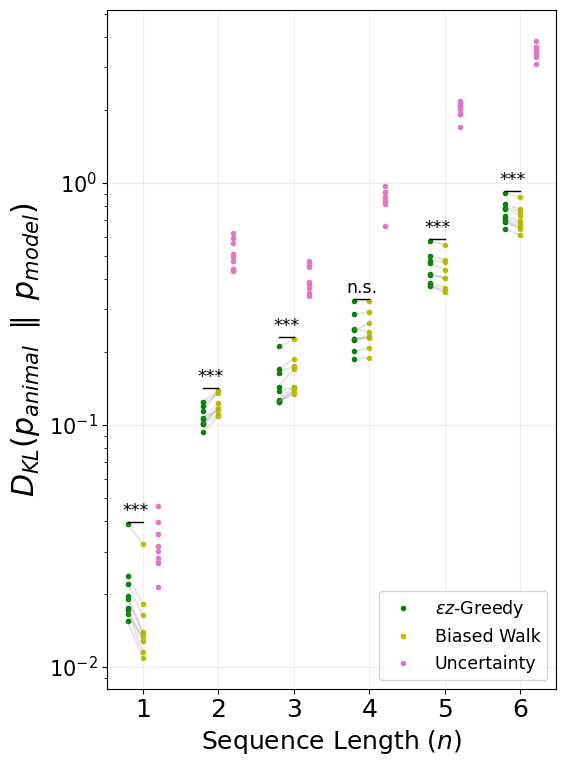

In [463]:
def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

def plot_kl():
    
    plt.figure(figsize=(6, 8))

    xticks = []
    for depth in entr_animal_tes:
#         if depth > 5:
#             continue

        t_stat, p_value = ttest_rel(entr_animal_tes[depth], entr_animal_bws[depth])
        print("depth", depth)
        print("t-statistic:", t_stat)
        print("p-value:", p_value)
        stars = get_stars(p_value)
        
        n = len(entr_animal_tes[depth])
        x1 = depth-0.2
        x2 = depth+0.
        x3 = depth+0.2
        jitter0 = np.zeros(n)
        jitter1 = np.random.uniform(-0.02, 0.02, size=n)

        plt.plot(x1 + jitter0, entr_animal_tes[depth], f'{model_colors["TeAltOptions"]}', marker='.', linestyle='None', label=labels['TeAltOptions'] if depth == 1 else '')
        plt.plot(x2 + jitter0, entr_animal_bws[depth], f'{model_colors["BiasedWalk4"]}', marker='.', linestyle='None', label=labels['BiasedWalk4'] if depth == 1 else '')
        plt.plot(x3 + jitter0, entr_animal_uncs[depth], f'{model_colors["Uncertainty"]}', marker='.', linestyle='None', label=labels['Uncertainty'] if depth == 1 else '')

        for i in range(len(entr_animal_tes[depth])):
            plt.plot([x1, x2], [entr_animal_tes[depth][i], entr_animal_bws[depth][i]], color='gray', alpha=0.2)

        # Add p-value line and stars
        y_max = max(max(entr_animal_tes[depth]), max(entr_animal_bws[depth]))
        y_line = y_max + 0.02 * y_max
        plt.plot([x1, x2], [y_line, y_line], color='black', linewidth=1)
        plt.text((x1+x2)/2, y_line + 0.02 * y_max, stars, ha='center', va='bottom', fontsize='x-small')
        xticks.append(depth)
    
    plt.ylabel('$D_{KL}$($p_{animal}$ $\parallel$ $p_{model})$', fontsize='large')
    plt.xlabel('Sequence Length ($n$)', fontsize='medium')
    plt.yticks(fontsize='small')
    plt.xticks(xticks)
    plt.legend(loc='lower right', fontsize='x-small')
    plt.yscale('log')

#     plt.margins(y=0.1)
    plt.tight_layout()
    plt.grid(alpha=0.2)
    plt.savefig(f'{figpath}/kl_var={var}_tju={tju}_all.pdf', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()
    return


plot_kl()

In [ ]:
# some analyses on probability distributions (unfinished).

In [311]:
np.unique(np.array(list(pt_dict_animal.keys()))[:, -2], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 array([18, 24, 24, 27, 27, 24, 27, 24, 27, 27, 24, 27, 27, 27, 24, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 24, 27, 27, 24, 27, 27, 27, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]))

In [312]:
[print(_) for _ in (np.array(list(pt_dict_tealtopt.keys())))]
print()

[0 0 4 0]
[0 0 4 1]
[0 0 4 2]
[0 0 9 0]
[0 0 9 1]
[0 0 9 2]
[ 0  0 20  0]
[ 0  0 20  1]
[ 0  0 20  2]
[ 0  0 41  0]
[ 0  0 41  1]
[ 0  0 41  2]
[ 0  1 20  0]
[ 0  1 20  1]
[ 0  1 20  2]
[1 2 9 0]
[1 2 9 1]
[1 2 9 2]
[1 2 1 0]
[1 2 1 1]
[1 2 1 2]
[2 1 0 0]
[2 1 0 1]
[2 1 0 2]
[1 0 1 0]
[1 0 1 1]
[1 0 1 2]
[ 0  2 41  0]
[ 0  2 41  1]
[ 0  2 41  2]
[ 0  1 41  0]
[ 0  1 41  1]
[ 0  1 41  2]
[ 1  1 20  0]
[ 1  1 20  1]
[ 1  1 20  2]
[2 1 4 0]
[2 1 4 1]
[2 1 4 2]
[ 1  0 10  0]
[ 1  0 10  1]
[ 1  0 10  2]
[0 2 4 0]
[0 2 4 1]
[0 2 4 2]
[ 2  0 10  0]
[ 2  0 10  1]
[ 2  0 10  2]
[2 2 1 0]
[2 2 1 1]
[2 2 1 2]
[2 0 4 0]
[2 0 4 1]
[2 0 4 2]
[ 0  0 10  0]
[ 0  0 10  1]
[ 0  0 10  2]
[ 0  0 22  0]
[ 0  0 22  1]
[ 0  0 22  2]
[ 0  0 46  0]
[ 0  0 46  1]
[ 0  0 46  2]
[ 0  1 46  0]
[ 0  1 46  1]
[ 0  1 46  2]
[ 1  2 22  0]
[ 1  2 22  1]
[ 1  2 22  2]
[ 2  0 45  0]
[ 2  0 45  1]
[ 2  0 45  2]
[ 0  2 45  0]
[ 0  2 45  1]
[ 0  2 45  2]
[ 0  1 45  0]
[ 0  1 45  1]
[ 0  1 45  2]
[ 1  1 22  0]
[ 1  1 22  1]


In [388]:
from collections import defaultdict
probs_at_node_te = defaultdict(list)
probs_at_node_bw = defaultdict(list)
for seq in pt_dict_tealtopt:
    node = seq[-2]
    act = seq[-1]
    if node == 0:
        print(seq)
    probs_at_node_te[node].append(pt_dict_tealtopt[seq])
    probs_at_node_bw[node].append(pt_dict_bw[seq])

(2, 1, 0, 0)
(2, 1, 0, 1)
(2, 1, 0, 2)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 0, 2)
(2, 2, 0, 0)
(2, 2, 0, 1)
(2, 2, 0, 2)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 0, 2)
(1, 2, 0, 0)
(1, 2, 0, 1)
(1, 2, 0, 2)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)


In [389]:
np.array(list(zip(probs_at_node_te[0], probs_at_node_bw[0])))

array([[4.61183705e-01, 4.30320946e-01],
       [5.38560082e-01, 5.69256757e-01],
       [2.56213169e-04, 4.22297297e-04],
       [5.06742370e-01, 5.68245125e-01],
       [4.92547906e-01, 4.30826370e-01],
       [7.09723208e-04, 9.28505107e-04],
       [5.33454711e-01, 5.70275723e-01],
       [4.66090123e-01, 4.29051782e-01],
       [4.55166136e-04, 6.72494956e-04],
       [4.61645102e-01, 4.32065217e-01],
       [5.37892791e-01, 5.67255435e-01],
       [4.62107209e-04, 6.79347826e-04],
       [5.47174702e-01, 5.62222222e-01],
       [4.52566096e-01, 4.37333333e-01],
       [2.59201659e-04, 4.44444444e-04],
       [4.97319035e-01, 4.72636816e-01],
       [5.02010724e-01, 5.26368159e-01],
       [6.70241287e-04, 9.95024876e-04]])

In [390]:
kl_nodes = [1]*127
for _ in probs_at_node_te:
    kl_nodes[_] = np.sum(rel_entr(probs_at_node_bw[_], probs_at_node_te[_]))
#     kl_nodes[_] = np.sum(rel_entr(probs_at_node_te[_], probs_at_node_bw[_]))
kl_nodes

[0.016012138917868516,
 0.33419977365446185,
 0.3387752934112743,
 0.204403797455686,
 0.22531156956565046,
 0.21428373975827622,
 0.2779194033217214,
 0.21666024909196469,
 0.24911338109803405,
 0.2572426370670152,
 0.222039015301421,
 0.26039338596128137,
 0.2684075192432993,
 0.2663738038237513,
 0.317801551418871,
 0.25934576370655316,
 0.17809216239492864,
 0.22098976041064725,
 0.24517123774067578,
 0.18803654441767842,
 0.22113051880170417,
 0.2543853372425542,
 0.20922714695093178,
 0.20177247514963315,
 0.35684764230099797,
 0.1824693383827386,
 0.22708496607656908,
 0.24278415173883372,
 0.22249704440795104,
 0.18949244116581515,
 0.25902486228210425,
 0.12983099228246814,
 0.09471122759236533,
 0.10062023445304792,
 0.06512241236437791,
 0.04936304172914057,
 0.06497511997500033,
 0.07890631004396846,
 0.17152140711430766,
 0.07860517275162995,
 0.07957608525611573,
 0.150089783742121,
 0.0518712144896741,
 0.07045999848135213,
 0.031633438733812,
 0.10772164434427597,
 0.10

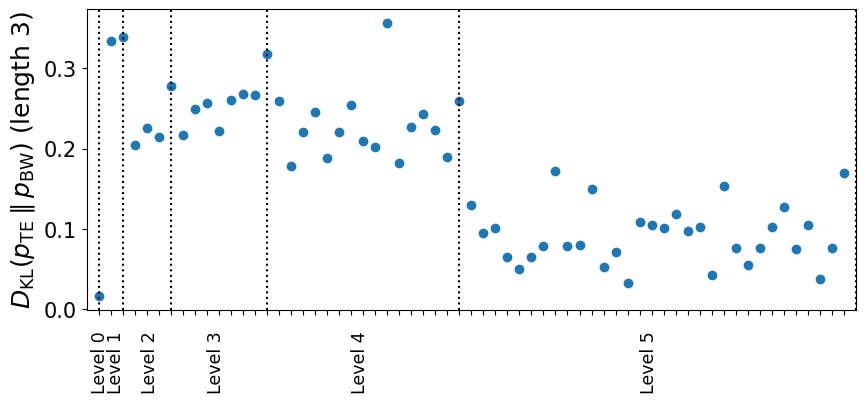

In [455]:
plt.figure(figsize=(9, 4.5))
plt.plot(kl_nodes[:63], 'o')
for _ in [0, 2, 6, 14, 30, 63]:
    plt.axvline(_, ls=':', c='k')

plt.xlim(-1, 63)
# plt.xlabel('Node', fontsize='medium')
plt.ylabel(r'$D_\mathrm{KL} (p_\mathrm{TE} \parallel p_\mathrm{BW}$) (length 3)', fontsize='medium')
plt.xticks(ticks=range(0, 63),labels=[],fontsize='small')
plt.yticks(fontsize='small')
plt.text(-0.6, -0.1, 'Level 0', rotation=90, fontsize='x-small')
plt.text(0.7, -0.1, 'Level 1', rotation=90, fontsize='x-small')
plt.text(3.5, -0.1, 'Level 2', rotation=90, fontsize='x-small')
plt.text(9, -0.1, 'Level 3', rotation=90, fontsize='x-small')
plt.text(21, -0.1, 'Level 4', rotation=90, fontsize='x-small')
plt.text(45, -0.1, 'Level 5', rotation=90, fontsize='x-small')
plt.tight_layout()
plt.savefig(f'{figpath}/diverge_from_bw.pdf', transparent=True, dpi=30, bbox_inches='tight')
plt.show()
plt.close()

In [316]:
def TranslLevelsLR(ma):
    '''
    discriminate by level and whether an L or an R node
    '''
    tra=np.zeros(2**(ma.le+1)-1,dtype=int) # number of node values
    tra[0]=0 # nodes level 0
    for k in range(1,ma.le+1): # nodes level 1,...
        for j in range(2**k-1,2**(k+1)-1):
            tra[j]=2*k-1+StepType(ma.pa[j],j,ma) # This distinguishes L from R nodes
    return tra
tr = TranslLevelsLR(NewMaze())
tr, tr.shape

(array([ 0,  1,  2,  3,  4,  4,  3,  6,  5,  5,  6,  6,  5,  5,  6,  7,  8,
         8,  7,  7,  8,  8,  7,  7,  8,  8,  7,  7,  8,  8,  7, 10,  9,  9,
        10, 10,  9,  9, 10, 10,  9,  9, 10, 10,  9,  9, 10, 10,  9,  9, 10,
        10,  9,  9, 10, 10,  9,  9, 10, 10,  9,  9, 10, 11, 12, 12, 11, 11,
        12, 12, 11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12,
        12, 11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12, 12,
        11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12, 12, 11, 11, 12, 12, 11,
        11, 12, 12, 11, 11, 12, 12, 11]),
 (127,))

In [317]:
nodes=range(127)
list(zip(nodes, tr))

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 4),
 (6, 3),
 (7, 6),
 (8, 5),
 (9, 5),
 (10, 6),
 (11, 6),
 (12, 5),
 (13, 5),
 (14, 6),
 (15, 7),
 (16, 8),
 (17, 8),
 (18, 7),
 (19, 7),
 (20, 8),
 (21, 8),
 (22, 7),
 (23, 7),
 (24, 8),
 (25, 8),
 (26, 7),
 (27, 7),
 (28, 8),
 (29, 8),
 (30, 7),
 (31, 10),
 (32, 9),
 (33, 9),
 (34, 10),
 (35, 10),
 (36, 9),
 (37, 9),
 (38, 10),
 (39, 10),
 (40, 9),
 (41, 9),
 (42, 10),
 (43, 10),
 (44, 9),
 (45, 9),
 (46, 10),
 (47, 10),
 (48, 9),
 (49, 9),
 (50, 10),
 (51, 10),
 (52, 9),
 (53, 9),
 (54, 10),
 (55, 10),
 (56, 9),
 (57, 9),
 (58, 10),
 (59, 10),
 (60, 9),
 (61, 9),
 (62, 10),
 (63, 11),
 (64, 12),
 (65, 12),
 (66, 11),
 (67, 11),
 (68, 12),
 (69, 12),
 (70, 11),
 (71, 11),
 (72, 12),
 (73, 12),
 (74, 11),
 (75, 11),
 (76, 12),
 (77, 12),
 (78, 11),
 (79, 11),
 (80, 12),
 (81, 12),
 (82, 11),
 (83, 11),
 (84, 12),
 (85, 12),
 (86, 11),
 (87, 11),
 (88, 12),
 (89, 12),
 (90, 11),
 (91, 11),
 (92, 12),
 (93, 12),
 (94, 11),
 (95, 11),
 

In [327]:
def PlotMazeFunctionNew(f,m,mode='cells',numcol='cyan',figsize=4,col=None,axes=None):
    '''
    Plot the maze defined in m with a function f overlaid in color
    f[]: array of something as a function of place in the maze, e.g. cell occupancy
        If f is None then the shading is omitted
    m: maze structure
    mode: 'cells','runs','nodes': depending on whether f[] is associated with either of these
    numcol: color for the numbers. If numcol is None the numbers are omitted
    figsize: in inches
    col: a color scale to map f[] into colors. nx4 ndarray. 
        col[j,0]=value of f associated with this color
        col[j,1:4]=rgb values of this color, each in the range [0,1]
        if col==None then the color scale is from 0=white to 1=black
    Returns: the axes of the plot.
    '''		
    if col is None:
        col=np.array([[0,1,1,1],[1,0,0,0]]) # default 0=white to 1=black 

    def Color(x): 
        return [np.interp(x,col[:,0],col[:,j]) for j in [1,2,3]]

    if axes:
        ax=axes
        PlotMazeWall(m,axes=ax,figsize=figsize)
    else:
        ax=PlotMazeWall(m,axes=None,figsize=figsize)

    if mode=='nodes':
        for j,r in enumerate(m.ru):
            x = m.xc[r[-1]]; y=m.yc[r[-1]]
            if not(f is None):
                ax.add_patch(patches.Rectangle((x-0.5,y-0.5),1,1,lw=0,
                                           color=Color(f[j]))) # draw with color f[]
            if numcol:
                plt.text(x-.35,y+.15,'{:d}'.format(j),color=numcol) # number the ends of a run                
    return ax

In [336]:
ma = NewMaze()
ma.ru

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23],
 [24, 25, 26, 27],
 [28, 29, 30, 31],
 [32, 33],
 [34, 35],
 [36, 37],
 [38, 39],
 [40, 41],
 [42, 43],
 [44, 45],
 [46, 47],
 [48, 49],
 [50, 51],
 [52, 53],
 [54, 55],
 [56, 57],
 [58, 59],
 [60, 61],
 [62, 63],
 [64, 65],
 [66, 67],
 [68, 69],
 [70, 71],
 [72, 73],
 [74, 75],
 [76, 77],
 [78, 79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [140],
 [141],
 [142],
 [143],
 [144],
 [145],
 [146],
 [147],
 [148],
 [149],
 [150],
 [151],
 [152],
 [153],
 [154],
 [155],
 [156],
 